## Keras Sequantial Model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
pd.set_option('display.max_columns', 999)

from sklearn import preprocessing
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow_core.estimator import inputs
from tensorflow import feature_column
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import initializers

from tensorflow.keras.models import load_model
from keras.utils import to_categorical

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

from  IPython import display
from matplotlib import pyplot as plt

import numpy as np
import math

import pathlib
import shutil
import tempfile


Using TensorFlow backend.


### Define functions

In [18]:
def normalize_try(dataframe):
    highestValue = 0;
    ds = np.full((dataframe.shape[0], dataframe.shape[1]), 0)
    for i in range(dataframe.shape[0]):
        for j in range(dataframe.shape[1]):
            if highestValue < dataframe[i][j]:
                highestValue = dataframe[i][j]
    
    for i in range(dataframe.shape[0]):
        for j in range(dataframe.shape[1]):
                dataframe[i][j] = (dataframe[i][j]/highestValue)
    
    return dataframe
                



def encode(i):
    switcher = {
        "H": 2,
        "D": 1,
        "A": 0,
        }
    # 1 be assigned as default value of passed argument (if goals > 5)
    return switcher.get(i, 1)

def normalize_and_encode(dataframe):
    column_names_to_not_normalize = ['result']
    column_names_to_normalize = [x for x in list(dataframe) if x not in column_names_to_not_normalize ]
    x = dataframe[column_names_to_normalize].values
    x_scaled = preprocessing.normalize(x) #vom alten
    std_scale = preprocessing.MinMaxScaler().fit(x)
    #x_train_norm = std_scale.transform(x)
    x_train_norm = normalize_try(x)
    df_temp = pd.DataFrame(x_train_norm, columns=column_names_to_normalize, index = dataframe.index)
    dataframe[column_names_to_normalize] = df_temp

    #dataframe['result'] = dataframe.apply(lambda row: encode(row['result']), axis=1)

    le = preprocessing.LabelEncoder()
    le.fit([ "H", "D", "A"])
    dataframe.loc[:,['result']]=le.transform(dataframe['result'])
    
    return dataframe

def get_X_and_y(dataframe):
    X = dataframe.drop(columns=['result']).values
    y = dataframe[['result']].values
    return X,y


#def get_lr_schedule(train, batch_size):
    #lr_schedule = tf.keras.optimizers.SGD(lr=0.001, clipvalue=0.5)
    #tf.keras.optimizers.schedules.InverseTimeDecay(
    #0.0001, # lr??
    #decay_steps=(len(train)//batch_size)*1000,
    #decay_rate=1,
    #staircase=False)
    #return lr_schedule

def get_optimizer(train, batch_size):
    return tf.keras.optimizers.SGD(lr=0.01, momentum=0.9) 
            #tf.keras.optimizers.Adam(get_lr_schedule(train, batch_size))


def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        #tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200),
        #tf.keras.callbacks.TensorBoard(logdir/name), # Jupyter Notebook
        #tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1) # Google Colab
      ]

def compile_and_fit(model, name, X, y, validation_split, batch_size, optimizer=None, max_epochs=1000):
    if optimizer is None:
        optimizer = get_optimizer(X, batch_size)
    model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

    model.summary()
     
    history = model.fit(
        X,
        y,
        validation_split=validation_split,
        batch_size=batch_size,
        epochs=max_epochs,
        callbacks=get_callbacks(name),
        verbose=0)
    
    model.save("../model/%s.h5" %name) 
    
    return history

def plot_history(model_history):
	plt.plot(model_history.history['accuracy'])
	plt.plot(model_history.history['val_accuracy'])
	plt.title("%s accuracy" %model_history)
	plt.ylabel('accuracy')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()
	
	plt.plot(model_history.history['loss'])
	plt.plot(model_history.history['val_loss'])
	plt.title("%s loss" %model_history)
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'val'], loc='upper left')
	plt.show()

### Read the sliding window + Preprocessing

In [19]:
df02 = pd.read_csv('../data/data_classification_results/sliding02_shots.csv', sep=',', index_col=0)
df02


,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,H,3.50,3.30,2.10,1,3,6,11,16,137,67,117,53,8,2,0,15,6,161,78,72,30
1,D,2.50,3.30,2.88,3,1,6,8,16,134,64,151,77,3,3,4,11,18,104,44,87,36
2,A,1.91,3.40,4.20,4,2,4,10,15,120,58,124,56,2,2,6,11,15,134,59,100,46
3,H,3.25,3.25,2.30,5,2,3,22,12,177,82,74,37,6,3,1,19,8,169,95,113,58
4,H,1.20,6.00,19.00,7,2,1,15,8,161,72,74,31,3,2,5,10,17,143,69,134,69
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,H,5.00,3.80,1.70,4,2,4,10,12,80,43,117,60,2,4,4,10,21,119,58,112,65
7029,H,2.00,3.60,3.70,3,2,5,9,21,89,47,92,46,1,4,5,7,21,104,55,63,26
7030,H,1.80,3.75,4.50,3,3,4,8,8,122,59,92,50,5,2,3,15,9,84,43,118,56
7031,H,1.33,5.25,9.00,2,3,5,12,14,124,62,99,50,3,3,4,11,17,103,53,122,54


In [20]:
n02 = normalize_and_encode(df02)


train02, test02 = train_test_split(n02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')


train_X02,train_y02 = get_X_and_y(train02)

test_X02,test_y02 = get_X_and_y(test02)

train_y02 = to_categorical(train_y02)
test_y02 = to_categorical(test_y02)

6329 train examples
704 test examples


In [21]:
n02

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
0,2,0.015837,0.014932,0.009502,0.004525,0.013575,0.027149,0.049774,0.072398,0.619910,0.303167,0.529412,0.239819,0.036199,0.009050,0.000000,0.067873,0.027149,0.728507,0.352941,0.325792,0.135747
1,1,0.011312,0.014932,0.013032,0.013575,0.004525,0.027149,0.036199,0.072398,0.606335,0.289593,0.683258,0.348416,0.013575,0.013575,0.018100,0.049774,0.081448,0.470588,0.199095,0.393665,0.162896
2,0,0.008643,0.015385,0.019005,0.018100,0.009050,0.018100,0.045249,0.067873,0.542986,0.262443,0.561086,0.253394,0.009050,0.009050,0.027149,0.049774,0.067873,0.606335,0.266968,0.452489,0.208145
3,2,0.014706,0.014706,0.010407,0.022624,0.009050,0.013575,0.099548,0.054299,0.800905,0.371041,0.334842,0.167421,0.027149,0.013575,0.004525,0.085973,0.036199,0.764706,0.429864,0.511312,0.262443
4,2,0.005430,0.027149,0.085973,0.031674,0.009050,0.004525,0.067873,0.036199,0.728507,0.325792,0.334842,0.140271,0.013575,0.009050,0.022624,0.045249,0.076923,0.647059,0.312217,0.606335,0.312217
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7028,2,0.022624,0.017195,0.007692,0.018100,0.009050,0.018100,0.045249,0.054299,0.361991,0.194570,0.529412,0.271493,0.009050,0.018100,0.018100,0.045249,0.095023,0.538462,0.262443,0.506787,0.294118
7029,2,0.009050,0.016290,0.016742,0.013575,0.009050,0.022624,0.040724,0.095023,0.402715,0.212670,0.416290,0.208145,0.004525,0.018100,0.022624,0.031674,0.095023,0.470588,0.248869,0.285068,0.117647
7030,2,0.008145,0.016968,0.020362,0.013575,0.013575,0.018100,0.036199,0.036199,0.552036,0.266968,0.416290,0.226244,0.022624,0.009050,0.013575,0.067873,0.040724,0.380090,0.194570,0.533937,0.253394
7031,2,0.006018,0.023756,0.040724,0.009050,0.013575,0.022624,0.054299,0.063348,0.561086,0.280543,0.447964,0.226244,0.013575,0.013575,0.018100,0.049774,0.076923,0.466063,0.239819,0.552036,0.244344


In [22]:
byhomegoal = df02.groupby('result')
byhomegoal.size().sort_values(ascending=False)

result
2    3238
0    2035
1    1760
dtype: int64

In [23]:
fdA = df02[df02.result == 0].head(1760)
fdD = df02[df02.result == 1].head(1760)
fdH = df02[df02.result == 2].head(1760)
df02 = pd.concat([fdA, fdD])
df02 = pd.concat([df02, fdH])

df02

,result,odds-home,odds-draw,odds-away,home-wins,home-draws,home-losses,home-goals,home-opposition-goals,home-shots,home-shots_on_target,home-opposition_shots,home-opposition_shots_on_target,away-wins,away-draws,away-losses,away-goals,away-opposition-goals,away-shots,away-shots_on_target,away-opposition_shots,away-opposition_shots_on_target
2,0,0.008643,0.015385,0.019005,0.018100,0.009050,0.018100,0.045249,0.067873,0.542986,0.262443,0.561086,0.253394,0.009050,0.009050,0.027149,0.049774,0.067873,0.606335,0.266968,0.452489,0.208145
5,0,0.010769,0.014932,0.013575,0.013575,0.013575,0.018100,0.040724,0.049774,0.461538,0.212670,0.601810,0.348416,0.018100,0.009050,0.018100,0.049774,0.058824,0.570136,0.266968,0.552036,0.266968
6,0,0.011765,0.014706,0.012670,0.018100,0.004525,0.022624,0.067873,0.072398,0.565611,0.285068,0.692308,0.330317,0.018100,0.013575,0.013575,0.058824,0.072398,0.466063,0.230769,0.624434,0.343891
7,0,0.010181,0.014706,0.015385,0.022624,0.009050,0.013575,0.067873,0.076923,0.402715,0.167421,0.782805,0.330317,0.009050,0.009050,0.027149,0.031674,0.054299,0.579186,0.289593,0.669683,0.334842
9,0,0.007692,0.017195,0.022624,0.027149,0.009050,0.009050,0.076923,0.049774,0.429864,0.190045,0.647059,0.330317,0.013575,0.009050,0.022624,0.040724,0.067873,0.475113,0.230769,0.723982,0.357466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3747,2,0.007692,0.017195,0.021493,0.013575,0.013575,0.018100,0.067873,0.072398,0.547511,0.289593,0.443439,0.276018,0.013575,0.013575,0.018100,0.045249,0.054299,0.447964,0.190045,0.506787,0.285068
3749,2,0.010769,0.014932,0.013122,0.018100,0.013575,0.013575,0.031674,0.049774,0.583710,0.303167,0.565611,0.235294,0.022624,0.009050,0.013575,0.108597,0.076923,0.556561,0.248869,0.583710,0.294118
3750,2,0.008145,0.015837,0.020362,0.045249,0.000000,0.000000,0.104072,0.004525,0.823529,0.375566,0.307692,0.144796,0.022624,0.013575,0.009050,0.063348,0.049774,0.592760,0.248869,0.452489,0.217195
3751,2,0.006787,0.018100,0.031674,0.027149,0.009050,0.009050,0.072398,0.040724,0.642534,0.343891,0.393665,0.194570,0.004525,0.013575,0.027149,0.031674,0.072398,0.506787,0.244344,0.524887,0.244344


In [24]:
byhomegoal = df02.groupby('result')
byhomegoal.size().sort_values(ascending=False)

result
2    1760
1    1760
0    1760
dtype: int64

train02, test02 = train_test_split(df02, test_size=0.1, shuffle=False)
print(len(train02), 'train examples')
print(len(test02), 'test examples')


train_X02,train_y02 = get_X_and_y(train02)

test_X02,test_y02 = get_X_and_y(test02)

train_y02 = to_categorical(train_y02)
test_y02 = to_categorical(test_y02)

In [25]:
train_y02

array([[0., 0., 1.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [1., 0., 0.],
       [0., 0., 1.]], dtype=float32)

### Define the model

logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


BATCH_SIZE = 20
EPOCHS=10000
validation_split = 0.2
size_histories = {}

model02_H3_M = tf.keras.Sequential([
  layers.Dense(35, activation='relu',input_shape=(train_X02.shape[1],)), # 21 features
  layers.Dropout(0.2),
  layers.Dense(20, activation='relu'),
  layers.Dropout(0.2),
  layers.Dense(10, activation='relu'),
  #layers.Dropout(0.2),
  layers.Dense(3, activation='softmax'),
  
])

In [26]:
logdir = pathlib.Path(tempfile.mkdtemp())/"tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)


BATCH_SIZE = 120
EPOCHS=10000
validation_split = 0.2
size_histories = {}

model02_H3_M = tf.keras.Sequential([
  layers.Dense(35, activation='relu',input_shape=(train_X02.shape[1],)), # 21 features
  layers.Dropout(0.2),
  layers.Dense(20, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  layers.Dropout(0.2),
  layers.Dense(10, activation='relu',kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  #layers.Dropout(0.2),
  layers.Dense(3, activation='softmax', kernel_initializer=initializers.RandomNormal(stddev=0.01),
  bias_initializer=initializers.Zeros()),
  
])

In [27]:
model02_H3_M.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=[ "acc"])

In [28]:
predictedResult = model02_H3_M.predict(test_X02, batch_size=BATCH_SIZE)
predictedResult

array([[0.33333334, 0.3333346 , 0.33333203],
       [0.33333325, 0.33333454, 0.33333218],
       [0.33333337, 0.33333445, 0.33333218],
       ...,
       [0.33333334, 0.3333346 , 0.33333206],
       [0.3333333 , 0.33333468, 0.333332  ],
       [0.33333334, 0.33333454, 0.33333212]], dtype=float32)

In [29]:
ynew = model02_H3_M.predict_classes(test_X02)
ynew

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [30]:
size_histories['model02_H3_M'] = compile_and_fit(model02_H3_M, 'model02_H3_M', train_X02, train_y02, validation_split=validation_split,batch_size=BATCH_SIZE, max_epochs=EPOCHS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 35)                770       
_________________________________________________________________
dropout (Dropout)            (None, 35)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                720       
_________________________________________________________________
dropout_1 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                210       
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 33        
Total params: 1,733
Trainable params: 1,733
Non-trainable params: 0
______________________________________________________

....................................................................................................
Epoch: 3800, accuracy:0.5453,  loss:0.9582,  val_accuracy:0.4937,  val_loss:1.0116,  
....................................................................................................
Epoch: 3900, accuracy:0.5465,  loss:0.9564,  val_accuracy:0.4889,  val_loss:1.0249,  
....................................................................................................
Epoch: 4000, accuracy:0.5465,  loss:0.9570,  val_accuracy:0.4889,  val_loss:1.0149,  
....................................................................................................
Epoch: 4100, accuracy:0.5505,  loss:0.9534,  val_accuracy:0.4882,  val_loss:1.0092,  
....................................................................................................
Epoch: 4200, accuracy:0.5489,  loss:0.9518,  val_accuracy:0.4882,  val_loss:1.0118,  
.................................................................

....................................................................................................
Epoch: 8200, accuracy:0.5611,  loss:0.9420,  val_accuracy:0.4882,  val_loss:1.0171,  
....................................................................................................
Epoch: 8300, accuracy:0.5538,  loss:0.9443,  val_accuracy:0.4945,  val_loss:1.0234,  
....................................................................................................
Epoch: 8400, accuracy:0.5570,  loss:0.9419,  val_accuracy:0.4882,  val_loss:1.0205,  
....................................................................................................
Epoch: 8500, accuracy:0.5552,  loss:0.9455,  val_accuracy:0.4905,  val_loss:1.0276,  
....................................................................................................
Epoch: 8600, accuracy:0.5538,  loss:0.9451,  val_accuracy:0.4850,  val_loss:1.0223,  
.................................................................

### Load and test the model

In [31]:
model = load_model('../model/model02_H3_M.h5')
score = model.evaluate(test_X02, test_y02, verbose=3)
print("model02_H3_M")
print("Loss:", score[0])
print("Test Accuracy:", score[1])

model02_H3_M
Loss: 0.9696509675546126
Test Accuracy: 0.53409094


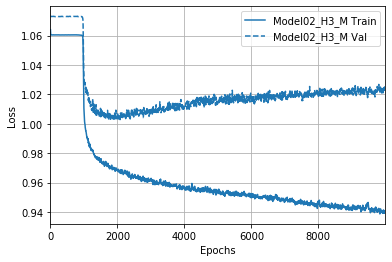

In [32]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'loss', smoothing_std=10)
plotter.plot(size_histories)

In [33]:
predictedResult = model.predict(test_X02, batch_size=1)

In [34]:
predictedResult

array([[0.03222584, 0.02137494, 0.9463992 ],
       [0.18969478, 0.28162023, 0.528685  ],
       [0.5734929 , 0.2396584 , 0.18684871],
       ...,
       [0.19696744, 0.2706721 , 0.53236043],
       [0.09398375, 0.2387523 , 0.66726387],
       [0.18388881, 0.25853828, 0.5575729 ]], dtype=float32)

In [35]:
ynewtrin = model.predict_classes(train_X02)
ynewtrin

array([0, 2, 2, ..., 0, 0, 2], dtype=int64)

Prob: Predicting only two classes instead of 3!

In [36]:
ynew = model.predict_classes(test_X02)
ynew

array([2, 2, 0, 2, 0, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 0, 2, 2,
       2, 2, 2, 0, 2, 2, 2, 1, 2, 1, 2, 0, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2,
       0, 2, 2, 0, 2, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 0, 0, 2,
       0, 2, 0, 2, 2, 0, 0, 2, 2, 2, 2, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 2,
       2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 2, 1, 0, 2, 2, 0, 2, 0, 2, 1,
       2, 2, 2, 1, 2, 2, 2, 0, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2,
       0, 2, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 1, 2, 2, 2, 0, 0, 0, 2, 2, 2,
       2, 0, 1, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 1, 2, 2,
       2, 1, 1, 2, 0, 0, 0, 1, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 0, 0, 2, 0,
       2, 2, 0, 2, 0, 0, 0, 2, 2, 2, 2, 2, 2, 0, 1, 2, 2, 2, 2, 2, 2, 2,
       0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2,
       0, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 1, 2, 0,
       0, 2, 2, 0, 2, 2, 0, 0, 2, 2, 2, 0, 0, 2, 2,

In [37]:
test_y02 

array([[0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]], dtype=float32)